# Preprocess data

This notebook will be used to preprocess the data.

## Setup

First, some setup.

#### Mount Google drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Change to project directory

In [2]:
%cd "/content/gdrive/MyDrive/Deep Learning Big Project/Action_Detection_In_Videos"

/content/gdrive/.shortcut-targets-by-id/14xhStdAaLgUU-ZRG4Lhq65SP8P-ArhQQ/Deep Learning Big Project/Action_Detection_In_Videos


### Imports

In [3]:
import os
import shutil
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm.auto import tqdm, trange
from src import dataset, transforms, utils, functional as F

plt.rcParams["animation.html"] = "jshtml"

### Constants

In [4]:
root = os.path.join('datasets', 'ssv2_mini')
src_subdir = 'raw'
dstypes = ['train', 'test']
overwrite = False

mean = (0.4724, 0.4328, 0.4068)
std = (0.223, 0.2251, 0.2262)
num_frames = 10
crop_size = (216, 216)

test_idx = 412
test_figsize = (7, 7)

In [5]:
# mean, std = utils.calculate_statistics(os.path.join(root, subdir, 'train'))
# Output: 3480 clips [13:30,  3.57 clips/s, mean=(0.4724, 0.4328, 0.4068), std=(0.223, 0.2251, 0.2262)]

## Preprocessing

Now we will preprocess the data.

### Main function

In [6]:
def preprocess_data(root, src_subdir, dst_subdir, dstype, transform, overwrite=False):
    dst = os.path.join(root, dst_subdir, dstype)
    if os.path.exists(dst):
        if overwrite:
            shutil.rmtree(dst)
        else:
            print(f"'{dst}' already exists! To continue, set overwrite to True.")
            return
    
    tqdm.write(f"Preprocessing {src_subdir}/{dstype} → {dst_subdir}/{dstype}")
    
    ds = dataset.SSV2_Dataset(root, src_subdir, dstype, transform=transform)

    for idx in trange(len(ds), unit=' clips'):
        clip_id, cls_idx = ds.get_info(idx)
        
        dst_dir = os.path.join(root, dst_subdir, dstype, str(cls_idx))
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        
        dst = os.path.join(dst_dir, str(clip_id))
        clip = ds[idx][0].numpy()
        np.save(dst, clip)

### Video to image

In this section, we convert the input videos into processed images.

#### Image transform

In [7]:
image_transform = transforms.Compose([
    transforms.FirstFrame(),
    transforms.ToPILImage(),
    transforms.RandomCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

#### Test image transform

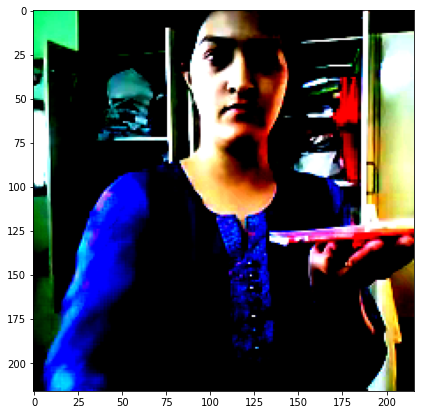

In [8]:
def test_image_transform(idx, figsize):
    ds = dataset.SSV2_Dataset(root, subdir, 'train', transform=image_transform)

    clip, label = ds[idx]
    img = clip.permute(1, 2, 0).clamp(0, 1).numpy()

    plt.figure(figsize=figsize)
    plt.imshow(img)

test_image_transform(test_idx, test_figsize)

#### Image preprocessing

In [9]:
for dstype in dstypes:
    preprocess_data(root, src_subdir, 'images', dstype, image_transform, overwrite=overwrite)

Preprocessing raw/train → images/train



Preprocessing raw/test → images/test


### Video to frames

In this section, we will convert to input video into processed video frames.

#### Video transform

In [10]:
video_transform = transforms.Compose([
    transforms.RandomFrames(num_frames),
    transforms.ToTensorVideo(),
    transforms.RandomCropVideo(crop_size),
    transforms.NormalizeVideo(mean, std),
])

#### Test video transform

In [11]:
def test_video_transform(idx, figsize):    
    ds = dataset.SSV2_Dataset(root, subdir, 'train', transform=video_transform)

    clip, label = ds[idx]

    def get_img(clip, i): # C x L x H x W
        img = clip[:, i, ...].numpy()
        return img.transpose(1, 2, 0).clip(0, 1) # H x W x C

    fig = plt.figure(figsize=figsize)
    im = plt.imshow(get_img(clip, 0))
    plt.close()

    i = 1
    def animate(i):
        im.set_array(get_img(clip, i))
        i += 1
        return im,
    return animation.FuncAnimation(fig, animate, frames=clip.size(1), blit=True)

test_video_transform(test_idx, test_figsize)

#### Video preprocessing

In [12]:
for dstype in dstypes:
    preprocess_data(root, src_subdir, 'frames', dstype, video_transform, overwrite=overwrite)

Preprocessing raw/train → frames/train



Preprocessing raw/test → frames/test


### Video to optical flow

In this section, we will convert the input video into optical flow data.

#### Flow transform

In [13]:
flow_transform = transforms.Compose([
    transforms.RandomFrames(num_frames),
    transforms.ToOpticalFlow(),
    transforms.ToTensorVideo(),
    transforms.RandomCropVideo(crop_size),
])

#### Test flow transform

In [14]:
def test_flow_transform(idx, figsize, step=3):
    # See https://stackoverflow.com/questions/61943240/quiver-plot-with-optical-flow
    ds = dataset.SSV2_Dataset(root, subdir, 'train', transform=flow_transform)

    flows, label = ds[idx]
    flow_len, h, w = flows.shape[1:]

    def get_flow(flows, i, c): # C x L x H x W
        flow = flows[c, i, ::step, ::step].numpy()
        return flow.clip(0, 1) # H x W
    
    fig = plt.figure(figsize=figsize)
    q = plt.quiver(
        np.arange(0, w, step),
        np.arange(h, 0, -step),
        get_flow(flows, 0, 0),
        get_flow(flows, 0, 1),
    )
    plt.close()

    i = 1
    def animate(i):
        q.set_UVC(get_flow(flows, i, 0), get_flow(flows, i, 1))
        i += 1
        return q,
    return animation.FuncAnimation(fig, animate, frames=flow_len, blit=True)

test_flow_transform(test_idx, test_figsize)

#### Optical flow preprocessing

In [15]:
for dstype in dstypes:
    preprocess_data(root, src_subdir, 'flows', dstype, flow_transform, overwrite=overwrite)

Preprocessing raw/train → flows/train



Preprocessing raw/test → flows/test
